In [765]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [766]:
import sys
sys.path.append('.')

import pandas as pd
import numpy as np
import incense
from incense import ExperimentLoader
import matplotlib.pyplot as plt
from src import settings

loader = ExperimentLoader(
    mongo_uri=None,    
    db_name='lions'
)

In [755]:
def find_similar(exp):
    """function to find based on hash.
    """
    hash_ = exp.to_dict()['config'][settings.EXP_HASH]
    return loader.find_by_config_key(settings.EXP_HASH, hash_)

def hash_based_bundle(exps):
    bundles = {}
    for exp in exps:
        hash_ = exp.to_dict()['config'][settings.EXP_HASH]
        if hash_ in bundles:
            bundles[hash_].append(exp)
        else:
            bundles[hash_] = [exp]
    return bundles

def get_bo_plots(exp):
    return {k: v for k,v in exp.artifacts.items() if k.startswith('bo-plot')}

# Show aggregate


In [756]:
# From one to all of same hash.

query = {"$and": [
            {"config.model.name": "GPModel"},
        ]}
exp = loader.find(query)[0]
exps = find_similar(exp)

In [757]:
# display name
# list of exp

def get_exp_key_col(exp):
    config = exp.to_dict()['config']
    return {
        'model': config['model']['name'],
        'model2': config.get('model2', {}).get('name', None),
        'acq': config.get('acquisition_function', {}).get('name'),
        'bo': bool(config.get('bo', None)),
        'f': config['obj_func']['name'],
        'config': config,
    }

exps = loader.find({'status': 'COMPLETED'})
bundles = hash_based_bundle(exps)
bundles = {k: dict(count=len(v), exps=v, **get_exp_key_col(v[0])) for k,v in bundles.items()}

df = pd.DataFrame.from_dict(bundles, orient='index')
df

,count,exps,model,model2,acq,bo,f,config
2f14477906bb50a7e19bc07292a3242353549fdd,6,"[Experiment(id=4, name=lions), Experiment(id=7...",GPModel,None,CurvatureAcquisition,True,Sinc,{'acquisition_function': {'name': 'CurvatureAc...
60519fa6dbfe5a80969a4b30ddd14cafbf68612f,4,"[Experiment(id=22, name=lions), Experiment(id=...",GPModel,None,CurvatureAcquisition,True,Kink1D,{'acquisition_function': {'name': 'CurvatureAc...
82495c9e9cd53a44d0902d1d7747d57948e3e6eb,6,"[Experiment(id=2, name=lions), Experiment(id=5...",GPModel,None,None,False,Sinc,{'exp_hash': '82495c9e9cd53a44d0902d1d7747d579...
8356d2f0fa47fcfe731ca0b3f0d053b00933121f,4,"[Experiment(id=21, name=lions), Experiment(id=...",GPModel,None,QuadratureAcquisition,True,Kink1D,{'acquisition_function': {'name': 'QuadratureA...
bcc45c47bfbf213bbd3fc2342f230019bbc5d606,1,"[Experiment(id=32, name=lions)]",GPModel,None,None,False,Kink2D,{'exp_hash': 'bcc45c47bfbf213bbd3fc2342f230019...
d9a0722520d418365cd04147526a7fa5e50d51f8,6,"[Experiment(id=3, name=lions), Experiment(id=6...",GPModel,None,QuadratureAcquisition,True,Sinc,{'acquisition_function': {'name': 'QuadratureA...
f53f413aa739ac60b96d1c8413732a1695586416,4,"[Experiment(id=20, name=lions), Experiment(id=...",GPModel,None,None,False,Kink1D,{'exp_hash': 'f53f413aa739ac60b96d1c8413732a16...


## Plot BO CI

In [758]:
#exps_row = df.loc[df.bo == True].iloc[0]
exps_row = df.loc["60519fa6dbfe5a80969a4b30ddd14cafbf68612f"]
exps = exps_row.exps

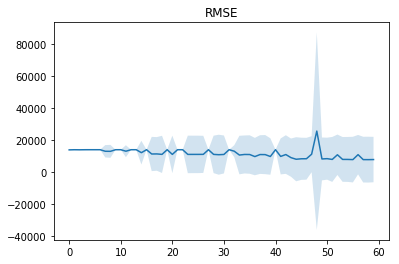

In [759]:
# Calculate mean and variance of MSE
# TODO: maybe not silence missing MSE...
df_concat = pd.concat([exp.metrics.get('mse',pd.Series([])) for exp in exps], axis=1)
mean = df_concat.mean(axis=1)
var = df_concat.var(axis=1)
plt.title('RMSE')
plt.plot(df_concat.index, mean)
plt.fill_between(df_concat.index, mean - 2 * np.sqrt(var), mean + 2 * np.sqrt(var), alpha=0.2)

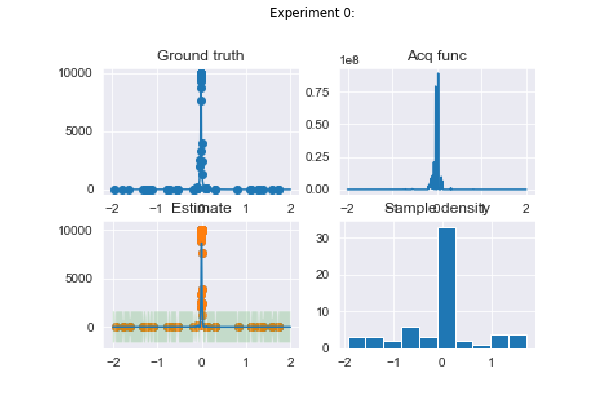

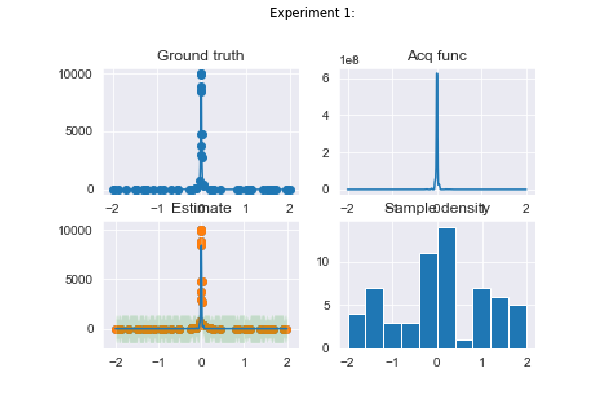

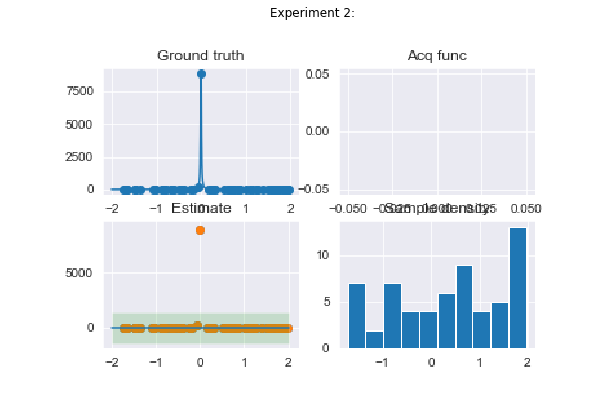

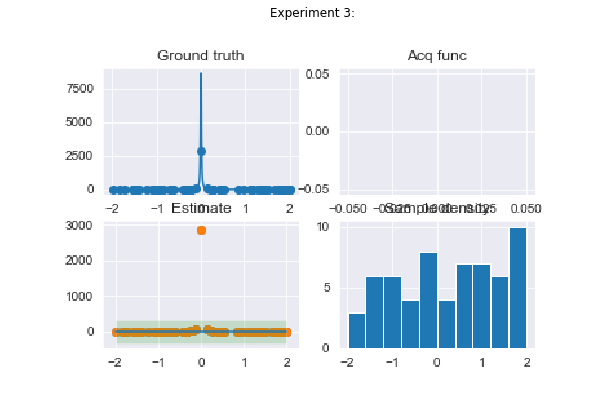

In [760]:
# Plot all last BO plot
# TODO: plot in grid
for i, exp in enumerate(exps):
    name, last_plot = sorted(get_bo_plots(exp).items())[-1]
    last_plot.show()
    plt.title("Experiment {}:".format(i))


## Plot GP final MSE

In [761]:
exps_rows_df = df
#exps_rows_df = exps_rows_df.loc[exps_rows_df.bo == False]
#exps_rows_df = exps_rows_df[exps_rows_df.f == 'Kink1D']
exps_rows_df = exps_rows_df[exps_rows_df.f == 'Kink1D']
#exps_rows_df = exps_rows_df[exps_rows_df.model == 'DKLGPModel']
exps_rows_df = exps_rows_df.copy()
exps_rows_df

,count,exps,model,model2,acq,bo,f,config
60519fa6dbfe5a80969a4b30ddd14cafbf68612f,4,"[Experiment(id=22, name=lions), Experiment(id=...",GPModel,None,CurvatureAcquisition,True,Kink1D,{'acquisition_function': {'name': 'CurvatureAc...
8356d2f0fa47fcfe731ca0b3f0d053b00933121f,4,"[Experiment(id=21, name=lions), Experiment(id=...",GPModel,None,QuadratureAcquisition,True,Kink1D,{'acquisition_function': {'name': 'QuadratureA...
f53f413aa739ac60b96d1c8413732a1695586416,4,"[Experiment(id=20, name=lions), Experiment(id=...",GPModel,None,None,False,Kink1D,{'exp_hash': 'f53f413aa739ac60b96d1c8413732a16...


In [762]:
exps_rows_df.loc['60519fa6dbfe5a80969a4b30ddd14cafbf68612f'].exps.pop()
exps_rows_df.loc['60519fa6dbfe5a80969a4b30ddd14cafbf68612f'].exps.pop()

Experiment(id=28, name=lions)

In [763]:
# Stats on result
exps_rows_df['rmse'] = exps_rows_df.apply(lambda row: np.array([e.result for e in row.exps], dtype=np.float), axis=1)
exps_rows_df['rmse_mean'] = exps_rows_df.apply(lambda row: np.nanmean(row.rmse), axis=1)
exps_rows_df['rmse_var'] = exps_rows_df.apply(lambda row: np.nanvar(row.rmse), axis=1)

# Create short hand name for convinience
def get_name(row):
    name = row.model
    if row.bo: 
        name = name + " BO"
    if row.acq is not None: 
        name = name + " " + row.acq
    name = name + " " + row.f
    return name

exps_rows_df['name'] = exps_rows_df.apply(get_name, axis=1)
exps_rows_df = exps_rows_df.set_index('name')

exps_rows_df

,count,exps,model,model2,acq,bo,f,config,rmse,rmse_mean,rmse_var
name,,,,,,,,,,,
GPModel BO CurvatureAcquisition Kink1D,4,"[Experiment(id=22, name=lions), Experiment(id=...",GPModel,None,CurvatureAcquisition,True,Kink1D,{'acquisition_function': {'name': 'CurvatureAc...,"[1571.415355495994, 1729.541118198903]",1650.478237,6250.939208
GPModel BO QuadratureAcquisition Kink1D,4,"[Experiment(id=21, name=lions), Experiment(id=...",GPModel,None,QuadratureAcquisition,True,Kink1D,{'acquisition_function': {'name': 'QuadratureA...,"[12753.516512168591, 13949.619505355258, 13949...",13650.593757,268249.194588
GPModel Kink1D,4,"[Experiment(id=20, name=lions), Experiment(id=...",GPModel,None,None,False,Kink1D,{'exp_hash': 'f53f413aa739ac60b96d1c8413732a16...,"[11927.504150179891, 13949.619508808562, 12891...",13088.577520,593717.695008


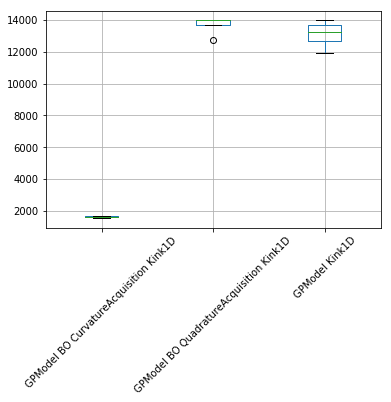

In [764]:
# Plot result (MSE) boxes!
exps_rows_df['rmse'].apply(lambda x: pd.Series(x)).T.boxplot(rot=45)

# (Temporary) Dumbster for scripting...

In [542]:
import numpy as np

D = 2
N_new = 5
N = 10

A = np.ones((N,D,D))
B = np.ones((N, N_new))
C = np.tensordot(B, A, axes=(0,0))
C.shape

(5, 2, 2)

In [543]:
Lambda = np.identity(D)
(Lambda @ C)

array([[[10., 10.],
        [10., 10.]],

       [[10., 10.],
        [10., 10.]],

       [[10., 10.],
        [10., 10.]],

       [[10., 10.],
        [10., 10.]],

       [[10., 10.],
        [10., 10.]]])

In [558]:
N = 2
D = 2
N_new = 3
A = np.arange(N * D).reshape(N, D)
B = np.arange(N_new * D).reshape(N_new, D)

(A[:, None, :] - B[None, :, :])

array([[[ 0,  0],
        [-2, -2],
        [-4, -4]],

       [[ 2,  2],
        [ 0,  0],
        [-2, -2]]])

In [523]:
X_new = np.arange(5 * 2).reshape((5, 2))
X = np.arange(10 * 2).reshape((10, 2))

np.einsum('ik,jk->ijk', X_new, -X).shape

(5, 10, 2)

In [538]:
X = np.arange(5)
La = np.ones(5 * 5).reshape((5, 5))
np.einsum("ij,i->i", La, X)

array([ 0.,  5., 10., 15., 20.])

In [527]:
# Summing a and b
k_Xx = np.ones((N_new, N, D))
Ones = np.ones((N_new, N, D, D))
alpha = np.ones((N, 1))

np.einsum("ijkl,ijk->ikl", Ones, k_Xx * alpha)
np.einsum("jik,jik->ik", k_Xx, k_Xx)

array([[5., 5.],
       [5., 5.],
       [5., 5.],
       [5., 5.],
       [5., 5.],
       [5., 5.],
       [5., 5.],
       [5., 5.],
       [5., 5.],
       [5., 5.]])

# Single experiment explorer

In [191]:
# Find the latest (using internal api of loader...)
exp = loader._runs.find().sort([('timestamp', -1)]).limit(1)[0]
exp = loader._make_experiment(exp)

In [192]:
#exp = loader.find_by_id(-1)

def artifact_to_numpy(artifact):
    return np.load(artifact.file)

X = artifact_to_numpy(exp.artifacts['X.npy'])
Y = artifact_to_numpy(exp.artifacts['Y.npy'])

bo_plots_dict = get_bo_plots(exp)
bo_plots = [bo_plots_dict[k] for k in sorted(bo_plots_dict.keys())]

In [193]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

@interact(i=(0, len(bo_plots)-1))
def show_bo_plot(i):
    bo_plots[i].show()

interactive(children=(IntSlider(value=0, description='i', max=1), Output()), _dom_classes=('widget-interact',)…

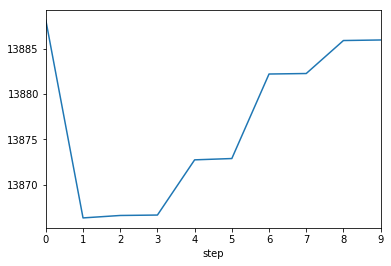

In [26]:
exp.metrics['mse'].plot()

## Reconstruct model

In [ ]:
# TODO:
# runner (in reconstruction mode)
# refit model

# Dangour Zone! (Used to clean mongodb)

In [560]:
for exp in loader.find({}):
    exp.delete()#confirmed=True)